# 차량 공유업체의 차량 파손 여부 분류

### 목표
 * 차량 공유업체의 차량 이미지를 CNN 모델을 활용해 파손 여부 분류
 * Data Augmentation - ImageGenerator로 데이터 추가 생성
 * InceptionV3 전이학습
 * Google Colab 활용

### 데이터
 * Car_Images.zip
    - 차량 외관 이미지 605개
    - abnormal(비정상, 파손 있음) 또는 normal(정상, 파손 없음)

## 1> 데이터 환경 구성

* 파일 압축 해제 후 train/test split
* Car_train, Car_val, Car_test 각각 abnormal, normal 구성 (Data Augmentation 에서 사용)
<br><br>
* abnormal, normal 통합

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile

In [3]:
os.getcwd()

'/content'

In [4]:
folder_path = "/content/drive/MyDrive/Datasets/"
zip_file_path = "Car_Images.zip"
root_path = "/content"

file_path = os.path.join(folder_path, zip_file_path)
extract_path = os.path.join(root_path, "Car_Images")
os.makedirs(extract_path, exist_ok=True)

In [5]:
extract_path

'/content/Car_Images'

In [6]:
    with zipfile.ZipFile(file_path, 'r') as zip_ext:
        zip_ext.extractall(extract_path)
    print(f"파일이 {extract_path} 경로에 성공적으로 압축 해제되었습니다.")

파일이 /content/Car_Images 경로에 성공적으로 압축 해제되었습니다.


In [7]:
train_folder = os.path.join(root_path, "Car_train")
val_folder = os.path.join(root_path, "Car_val")
test_folder = os.path.join(root_path, "Car_test")

os.makedirs(os.path.join(train_folder, "abnormal"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "normal"), exist_ok=True)

os.makedirs(os.path.join(val_folder, "abnormal"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "normal"), exist_ok=True)

os.makedirs(os.path.join(test_folder, "abnormal"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "normal"), exist_ok=True)

In [8]:
import random
import shutil

In [9]:
classes = ["abnormal", "normal"]

# 데이터 분할 비율 (7:1:2)
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

for cls in classes:
    src_dir = os.path.join(extract_path, cls)
    images = os.listdir(src_dir)
    random.shuffle(images) # 이미지 무작위로 섞기

    total_images = len(images)
    train_split = int(total_images * train_ratio)
    val_split = int(total_images * (train_ratio + val_ratio))

    # 이미지 복사
    for i, image in enumerate(images):
        src_path = os.path.join(src_dir, image)

        if i < train_split:
            dst_dir = os.path.join(train_folder, cls)
        elif i < val_split:
            dst_dir = os.path.join(val_folder, cls)
        else:
            dst_dir = os.path.join(test_folder, cls)

        dst_path = os.path.join(dst_dir, image)
        shutil.copy(src_path, dst_path)

In [10]:
print("train abnormal, normal 파일 개수")
print(len(os.listdir(os.path.join(train_folder, "abnormal"))), len(os.listdir(os.path.join(train_folder, "normal"))))

print("val abnormal, normal 파일 개수")
print(len(os.listdir(os.path.join(val_folder, "abnormal"))), len(os.listdir(os.path.join(val_folder, "normal"))))

print("test abnormal, normal 파일 개수")
print(len(os.listdir(os.path.join(test_folder, "abnormal"))), len(os.listdir(os.path.join(test_folder, "normal"))))

train abnormal, normal 파일 개수
212 211
val abnormal, normal 파일 개수
30 30
test abnormal, normal 파일 개수
61 61


* 이름 변경 및 데이터 복사

In [11]:
train_folder

'/content/Car_train'

In [12]:
base_folder = os.path.join(root_path, "base")
os.makedirs("base/train", exist_ok=True)
os.makedirs("base/val", exist_ok=True)
os.makedirs("base/test", exist_ok=True)

ab_no = ["abnormal", "normal"]

for ab in ab_no:
    for tr in os.listdir(os.path.join(train_folder, ab)):
        src = os.path.join(train_folder, ab, tr)
        dst = os.path.join(base_folder, "train", tr)
        shutil.copy(src, dst)

        if ab == "abnormal": # abnormal은 앞에 ab_ 추가
            tr_ab_new = os.path.join(base_folder, "train", ("ab_" + tr))
            os.rename(dst, tr_ab_new)

    for va in os.listdir(os.path.join(val_folder, ab)):
        src = os.path.join(val_folder, ab, va)
        dst = os.path.join(base_folder, "val", va)
        shutil.copy(src, dst)

        if ab == "abnormal":
            va_ab_new = os.path.join(base_folder, "val", ("ab_" + va))
            os.rename(dst, va_ab_new)

    for te in os.listdir(os.path.join(test_folder, ab)):
        src = os.path.join(test_folder, ab, te)
        dst = os.path.join(base_folder, "test", te)
        shutil.copy(src, dst)

        if ab == "abnormal":
            te_ab_new = os.path.join(base_folder, "test", ("ab_" + te))
            os.rename(dst, te_ab_new)

In [13]:
print("base train 파일 개수: ", end="")
print(len(os.listdir(os.path.join(base_folder, "train"))))

print("base val파일 개수: ", end="")
print(len(os.listdir(os.path.join(base_folder, "val"))))

print("base test파일 개수: ", end="")
print(len(os.listdir(os.path.join(base_folder, "test"))))

base train 파일 개수: 423
base val파일 개수: 60
base test파일 개수: 122


## 2> 데이터 전처리
 * x: 이미지 -> numpy array 변환
 * y: normal 0, abnormal 1인 array

In [303]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img

In [15]:
base_train_dir = os.path.join(base_folder, "train")
base_val_dir = os.path.join(base_folder, "val")
base_test_dir = os.path.join(base_folder, "test")

img_train = os.listdir(base_train_dir)
img_val = os.listdir(base_val_dir)
img_test = os.listdir(base_test_dir)

In [16]:
def img_to_array_resize(img_size):
    x_train, x_val, x_test = [], [], []

    for tr in img_train:
        img = load_img(os.path.join(base_train_dir, tr), target_size=(img_size, img_size))
        img = keras.utils.img_to_array(img)
        x_train.append(img)

    for va in img_val:
        img = load_img(os.path.join(base_val_dir, va), target_size=(img_size, img_size))
        img = keras.utils.img_to_array(img)
        x_val.append(img)

    for te in img_test:
        img = load_img(os.path.join(base_test_dir, te), target_size=(img_size, img_size))
        img = keras.utils.img_to_array(img)
        x_test.append(img)

    return np.array(x_train), np.array(x_val), np.array(x_test)

In [17]:
y_train, y_val, y_test = [], [], []

for x_tr in img_train:
    if x_tr.startswith('ab_'):
        y_train.append(1)
    else:
        y_train.append(0)

for x_va in img_val:
    if x_va.startswith('ab_'):
        y_val.append(1)
    else:
        y_val.append(0)

for x_te in img_test:
    if x_te.startswith('ab_'):
        y_test.append(1)
    else:
        y_test.append(0)

y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [18]:
y_train.shape, y_val.shape, y_test.shape

((423,), (60,), (122,))

* Min-Max Scaling

In [19]:
def MinMaxScaling(x_train, x_val, x_test):
    xmin, xmax = x_train.min(), x_train.max()

    x_train = (x_train - xmin) / (xmax - xmin)
    x_val = (x_val - xmin) / (xmax - xmin)
    x_test = (x_test - xmin) / (xmax - xmin)

    return x_train, x_val, x_test

### * 데이터 저장 및 불러오기

In [20]:
# np.savez_compressed(os.path.join(base_folder, "train"), x=x_train, y=y_train)
# np.savez_compressed(os.path.join(base_folder, "val"), x=x_val, y=y_val)
# np.savez_compressed(os.path.join(base_folder, "test"), x=x_test, y=y_test)

In [21]:
# trains = np.load(os.path.join(base_folder, "train.npz"))
# vals = np.load(os.path.join(base_folder, "val.npz"))
# tests = np.load(os.path.join(base_folder, "test.npz"))

# x_train, y_train = trains['x'], trains['y']
# x_val, y_val = vals['x'], vals['y']
# x_test, y_test = tests['x'], tests['y']

## 3> 모델1 AlexNet

<img src ="https://wikidocs.net/images/page/164787/AlexNet-Fig_02.png" width="600">

In [301]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [23]:
from keras.layers import Lambda

def lrn(x): ## LRN 구현
    return tf.nn.local_response_normalization(x)

#### 1) 구조 설계

In [24]:
AN_input_size = 227

In [241]:
# 세션 클리어, 모델 선언
clear_session()
model = Sequential()

# 모델 조립
model.add( Input(shape=(AN_input_size, AN_input_size, 3)) ) # (227, 227)

model.add( Conv2D(96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu') ) # (55, 55, 96)
model.add( Lambda(lrn) )
model.add( MaxPool2D(pool_size=(3,3), strides=(2,2)) ) # (27, 27, 96)

model.add( Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu') ) # (27, 27, 256)
model.add( Lambda(lrn) )
model.add( MaxPool2D(pool_size=(3,3), strides=(2,2)) ) # (13, 13, 256)

model.add( Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu') ) # (13, 13, 384)

model.add( Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu') ) # (13, 13, 384)

model.add( Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu') ) # (13, 13, 256)
model.add( MaxPool2D(pool_size=(3,3), strides=(2,2)) ) # (6, 6, 256)

model.add( Flatten() ) # (9216,)

model.add( Dense(4096, activation='relu') )
model.add( Dropout(0.5) )

model.add( Dense(4096, activation='relu') )
model.add( Dropout(0.5) )

model.add( Dense(1, activation='sigmoid') ) # 차량 파손 여부이므로 이진분류

# 컴파일
model.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,285,441 (222.34 MB)

 Trainable params: 58,285,441 (222.34 MB)

 Non-trainable params: 0 (0.00 B)

#### 2) 학습
* 이미지 사이즈 조정
* 정규화
* Early Stopping

In [26]:
x_train_an, x_val_an, x_test_an = MinMaxScaling( *img_to_array_resize(AN_input_size) ) # tuple unpack 주의

In [27]:
x_train_an.shape, x_val_an.shape, x_test_an.shape

((423, 227, 227, 3), (60, 227, 227, 3), (122, 227, 227, 3))

In [37]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [38]:
alexnet_hist = model.fit(x_train_an, y_train,
                         validation_data=(x_val_an, y_val), callbacks=[es],
                         epochs=1000, verbose=1)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5503 - loss: 0.6863 - val_accuracy: 0.6500 - val_loss: 0.6637
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6793 - loss: 0.6867 - val_accuracy: 0.5000 - val_loss: 0.6804
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5513 - loss: 0.6805 - val_accuracy: 0.6667 - val_loss: 0.6566
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6531 - loss: 0.6340 - val_accuracy: 0.6833 - val_loss: 0.6258
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6770 - loss: 0.6981 - val_accuracy: 0.5833 - val_loss: 0.6908
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4868 - loss: 0.7144 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4646 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.7010
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4874 - loss: 0.7001 - val_acc

In [243]:
model_an = model

In [48]:
def loss_acc_history(hist, figsize_=(10,4)):
    plt.figure(figsize=figsize_)

    plt.subplot(1,2,1)
    sns.lineplot(data=hist.history['accuracy'], label='Train Accuracy')
    sns.lineplot(data=hist.history['val_accuracy'], label='Validation Accuracy')
    plt.xticks(np.arange(0, len(hist.history['accuracy']), 2))
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    sns.lineplot(data=hist.history['loss'], label='Train Loss')
    sns.lineplot(data=hist.history['val_loss'], label='Validation Loss')
    plt.xticks(np.arange(0, len(hist.history['loss']), 2))
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

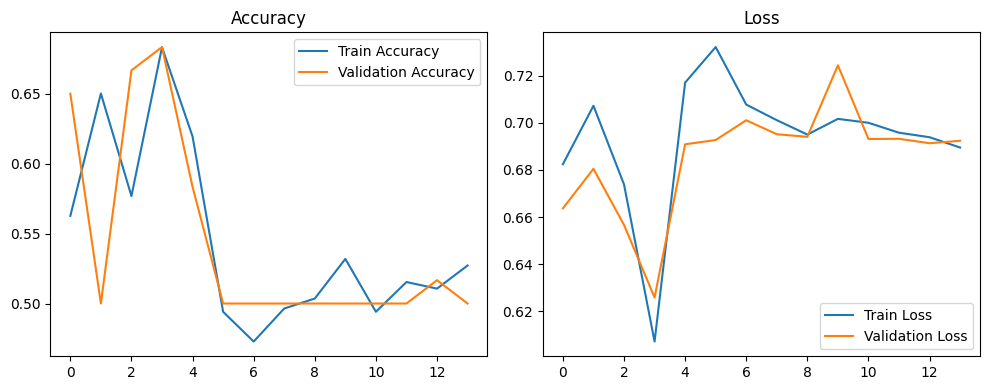

In [49]:
loss_acc_history(alexnet_hist)

#### 3) 예측 및 평가

In [50]:
y_pred_an = model.predict(x_test_an).reshape(-1)
y_pred_an.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


(122,)

In [51]:
y_pred_an[:5]

array([0.3901009 , 0.3378701 , 0.5700322 , 0.44084895, 0.46068966],
      dtype=float32)

In [52]:
# y_pred가 확률 값으로 나오므로 평가를 위해 값을 변형
y_pred_an2 = np.where(y_pred_an > 0.5, 1 , 0)
y_pred_an2[:5]

array([0, 0, 1, 0, 0])

In [53]:
print(confusion_matrix(y_test, y_pred_an2))
print(classification_report(y_test, y_pred_an2))

[[57  4]
 [26 35]]
              precision    recall  f1-score   support

           0       0.69      0.93      0.79        61
           1       0.90      0.57      0.70        61

    accuracy                           0.75       122
   macro avg       0.79      0.75      0.75       122
weighted avg       0.79      0.75      0.75       122



In [334]:
result_df = pd.DataFrame()

def df_accf1_concat(y_pred, model_name):
    acc = np.round(accuracy_score(y_test, y_pred), 4)
    f1 = np.round(f1_score(y_test, y_pred), 4)
    df = pd.DataFrame({'Accuracy': acc, 'F1_Score': f1}, index=[model_name])

    res = pd.concat([result_df, df])

    return res

In [335]:
result_df = df_accf1_concat(y_pred_an2, 'AlexNet')
result_df

,Accuracy,F1_Score
AlexNet,0.7541,0.7


## 4> 모델2 VGG16

<img src ="https://miro.medium.com/v2/resize:fit:857/1*AqqArOvacibWqeulyP_-8Q.png" width="500">

#### 1) 구조 설계

In [55]:
VGG_input_size = 224

In [118]:
# 세션 클리어
clear_session()

# 모델 조립
il = Input(shape=(VGG_input_size, VGG_input_size, 3)) # (224, 224)

hl1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(il) # (224, 224, 64)
hl1 = BatchNormalization()(hl1)
hl1 = Activation('relu')(hl1)
hl1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(hl1) # (224, 224, 64)
hl1 = BatchNormalization()(hl1)
hl1 = Activation('relu')(hl1)
hl1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl1) # (112, 112, 64)

hl2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(hl1) # (112, 112, 128)
hl2 = BatchNormalization()(hl2)
hl2 = Activation('relu')(hl2)
hl2 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(hl2) # (112, 112, 128)
hl2 = BatchNormalization()(hl2)
hl2 = Activation('relu')(hl2)
hl2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl2) # (56, 56, 128)

hl3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl2) # (56, 56, 256)
hl3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl3) # (56, 56, 256)
hl3 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl3) # (56, 56, 256)
hl3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl3) # (28, 28, 256)

hl4 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl3) # (28, 28, 512)
hl4 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl4) # (28, 28, 512)
hl4 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl4) # (28, 28, 512)
hl4 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl4) # (14, 14, 512)

hl5 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl4) # (14, 14, 512)
hl5 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl5) # (14, 14, 512)
hl5 = Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(hl5) # (14, 14, 512)
hl5 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl5) # (7, 7, 512)

hl6 = Flatten()(hl5) # (25088,)
hl6 = Dense(1024, activation='relu')(hl6)
hl6 = Dropout(0.3)(hl6)
hl6 = Dense(1024, activation='relu')(hl6)
hl6 = Dropout(0.3)(hl6)

ol = Dense(1, activation='sigmoid')(hl6)

model = Model(il, ol)

# 컴파일
model.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# 요약
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             

 Total params: 41,457,985 (158.15 MB)

 Trainable params: 41,457,217 (158.15 MB)

 Non-trainable params: 768 (3.00 KB)

#### 2) 학습
* 이미지 사이즈 조정
* 정규화
* EarlyStopping

In [57]:
x_train_vgg, x_val_vgg, x_test_vgg = MinMaxScaling( *img_to_array_resize(VGG_input_size) ) # tuple unpack 주의

In [58]:
x_train_vgg.shape, x_val_vgg.shape, x_test_vgg.shape

((423, 224, 224, 3), (60, 224, 224, 3), (122, 224, 224, 3))

In [99]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [119]:
vgg16_hist = model.fit(x_train_vgg, y_train,
                       validation_data=(x_val_vgg, y_val), callbacks=[es],
                       epochs=1000, verbose=1)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4778 - loss: 24.1636 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 523ms/step - accuracy: 0.6772 - loss: 0.6185 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 502ms/step - accuracy: 0.7194 - loss: 0.5656 - val_accuracy: 0.5000 - val_loss: 0.7947
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - accuracy: 0.8143 - loss: 0.4805 - val_accuracy: 0.5000 - val_loss: 2.1208
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.7159 - loss: 0.5416 - val_accuracy: 0.5000 - val_loss: 2.0924
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.8509 - loss: 0.3769 - val_accuracy: 0.5000 - val_loss: 4.2149
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.8626 - loss: 0.3461 - val_accuracy: 0.5000 - val_loss: 4.9523
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 479ms/step - accuracy: 0.8590 - loss: 0.32

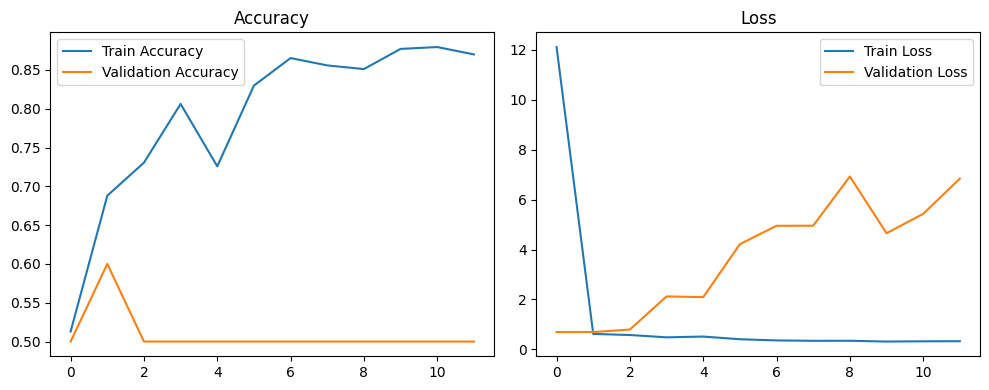

In [120]:
loss_acc_history(vgg16_hist)

#### 3) 예측 및 평가
* VGG16의 val_accuracy=0.5로 고정되는 현상을 보임. (모델이 무작위로 예측하는 것과 거의 동일한 수준)
    * 앞선 AlexNet에서는 정상 동작했으므로 데이터 문제가 아닌 모델 문제.
    * BatchNormalization 추가, Dropout 0.5->0.3, FC  4096->1024
    * (성능은 그다지 나아지지 않음.)

In [121]:
y_pred_vgg = model.predict(x_test_vgg).reshape(-1)
y_pred_vgg.shape

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step


(122,)

In [122]:
y_pred_vgg[:5]

array([0.6326347 , 0.61668265, 0.5278362 , 0.6246965 , 0.6399103 ],
      dtype=float32)

In [124]:
# y_pred가 확률 값으로 나오므로 평가를 위해 값을 변형
y_pred_vgg2 = np.where(y_pred_vgg > 0.5, 1 , 0)
y_pred_vgg2[:5]

array([1, 1, 1, 1, 1])

In [125]:
print(confusion_matrix(y_test, y_pred_vgg2))
print(classification_report(y_test, y_pred_vgg2))

[[ 3 58]
 [ 6 55]]
              precision    recall  f1-score   support

           0       0.33      0.05      0.09        61
           1       0.49      0.90      0.63        61

    accuracy                           0.48       122
   macro avg       0.41      0.48      0.36       122
weighted avg       0.41      0.48      0.36       122



In [336]:
result_df = df_accf1_concat(y_pred_vgg2, 'VGG16')
result_df

,Accuracy,F1_Score
AlexNet,0.7541,0.7000
VGG16,0.4754,0.6322


## 5> 모델3 이미지 크기 320
* 모델1, 2보다 약 50% 큰 이미지 사이즈로 성능 비교
* 모델 구조는 임의로 설계

### 1) 구조 설계

In [174]:
model3_input_size = 320

In [198]:
# 세션 클리어
clear_session()

# 모델 조립
il = Input(shape=(model3_input_size, model3_input_size, 3)) # (320, 320)

hl1 = Conv2D(filters=64, kernel_size=(8, 8), strides=(2, 2), padding='same', activation='relu')(il) # (160, 160, 64)
hl1 = Conv2D(filters=64, kernel_size=(8, 8), strides=(1, 1), padding='same', activation='relu')(hl1) # (160, 160, 64)
hl1 = Lambda(lrn)(hl1)
hl1 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl1) # (80, 80, 64)

hl2 = Conv2D(filters=128, kernel_size=(8, 8), strides=(2, 2), padding='same', activation='relu')(hl1) # (40, 40, 128)
hl2 = Conv2D(filters=128, kernel_size=(8, 8), strides=(1, 1), padding='same', activation='relu')(hl2) # (40, 40, 128)
hl2 = Lambda(lrn)(hl2)
hl2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(hl2) # (20, 20, 128)

hl3 = Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu')(hl2) # (10, 10, 256)
hl3 = Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(hl3) # (5, 5, 256)
hl3 = MaxPool2D(pool_size=(2,2), strides=(1,1))(hl3) # (4, 4, 256)

hl4 = Flatten()(hl3) # (4096,)
hl4 = Dense(1024, activation='relu')(hl4)
hl4 = Dropout(0.3)(hl4)
hl4 = Dense(1024, activation='relu')(hl4)
hl4 = Dropout(0.3)(hl4)

ol = Dense(1, activation='sigmoid')(hl4)

model = Model(il, ol)

# 컴파일
model.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=Adam())

# 요약
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 64)   │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 64)   │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 128)    │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,208,257 (31.31 MB)

 Trainable params: 8,208,257 (31.31 MB)

 Non-trainable params: 0 (0.00 B)

### 2) 학습
* 이미지 사이즈 조정
* 정규화
* EarlyStopping

In [181]:
x_train_m3, x_val_m3, x_test_m3 = MinMaxScaling( *img_to_array_resize(model3_input_size) ) # tuple unpack 주의

In [183]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [199]:
m3_hist = model.fit(x_train_m3, y_train,
                    validation_data=(x_val_m3, y_val), callbacks=[es],
                    epochs=1000, verbose=1)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 966ms/step - accuracy: 0.4739 - loss: 0.8452 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.4758 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.4897 - loss: 0.6992 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.5267 - loss: 0.7024 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.5333 - val_loss: 0.6907
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5383 - loss: 0.6906 - val_accuracy: 0.5500 - val_loss: 0.6748
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.5753 - loss: 0.6575 - val_accuracy: 0.6833 - val_loss: 0.6250
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6830 - loss: 0.6005 -

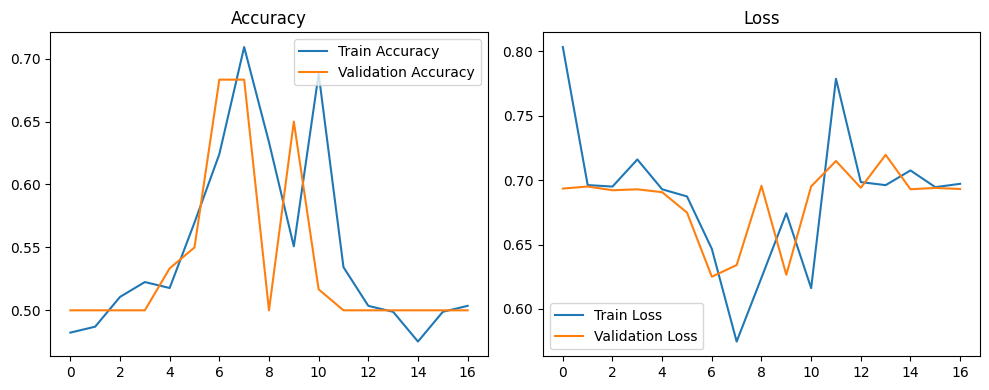

In [200]:
loss_acc_history(m3_hist)

### 3) 예측 및 평가

In [201]:
y_pred_m3 = model.predict(x_test_m3).reshape(-1)
y_pred_m3.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step


(122,)

In [202]:
y_pred_m3[:5]

array([0.45995754, 0.17801106, 0.5680988 , 0.5596286 , 0.5617796 ],
      dtype=float32)

In [203]:
# y_pred가 확률 값으로 나오므로 평가를 위해 값을 변형
y_pred_m3_2 = np.where(y_pred_m3 > 0.5, 1 , 0)
y_pred_m3_2[:5]

array([0, 0, 1, 1, 1])

In [212]:
print(confusion_matrix(y_test, y_pred_m3_2))
print(classification_report(y_test, y_pred_m3_2))

[[34 27]
 [11 50]]
              precision    recall  f1-score   support

           0       0.76      0.56      0.64        61
           1       0.65      0.82      0.72        61

    accuracy                           0.69       122
   macro avg       0.70      0.69      0.68       122
weighted avg       0.70      0.69      0.68       122



In [337]:
result_df = df_accf1_concat(y_pred_m3_2, 'My_Img320')
result_df

,Accuracy,F1_Score
AlexNet,0.7541,0.7000
VGG16,0.4754,0.6322
My_Img320,0.6885,0.7246


## 6> 모델4 AlexNet + Data Augmentation

### 1) 이미지 데이터 증강
* Keras의 [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * rotation_range: 무작위 회전을 적용할 각도 범위
    * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
    * horizontal_flip: 무작위 좌우반전을 적용할지 여부
    * vertical_flip: 무작위 상하반전을 적용할지 여부
    * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (여기서는 RGB 최대값인 255로 나누어서 0~1사이의 값으로 변경)



In [213]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [218]:
img_size = AN_input_size # 이미지 크기

train_path = "/content/Car_train"
val_path ="/content/Car_val"

In [231]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1./255)

val_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1./255)

### 2) 폴더에서 이미지 로드
* ImageDataGenerator.flow
    * 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성


In [238]:
# 증강 배율 설정 (원본 포함 총 4배)
augmentation_factor = 3

x_train_da, y_train_da = x_train_an.copy(), y_train.copy()
x_val_da, y_val_da = x_val_an.copy(), y_val.copy()

In [239]:
# 증강된 데이터 생성 및 병합
print("x_train before:", x_train_da.shape, "\ty_train before:", y_train_da.shape)
print("x_val before:", x_val_da.shape, "\ty_val before:", y_val_da.shape)
print("------------------------------------------------------------------")
train_generator = train_datagen.flow(x_train_an, y_train, batch_size=len(x_train_an), shuffle=False)
val_generator = val_datagen.flow(x_val_an, y_val, batch_size=len(x_val_an), shuffle=False)

for _ in range(augmentation_factor):
    x_aug, y_aug = train_generator.__next__()
    x_train_da = np.concatenate((x_train_da, x_aug))
    y_train_da = np.concatenate((y_train_da, y_aug))

    x_aug, y_aug = val_generator.__next__()
    x_val_da = np.concatenate( (x_val_da, x_aug) )
    y_val_da = np.concatenate( (y_val_da, y_aug) )

print("x_train after:", x_train_da.shape, "\ty_train after:", y_train_da.shape)
print("x_val after:", x_val_da.shape, "\ty_val after:", y_val_da.shape)

x_train before: (423, 227, 227, 3) 	y_train before: (423,)
x_val before: (60, 227, 227, 3) 	y_val before: (60,)
------------------------------------------------------------------
x_train after: (1692, 227, 227, 3) 	y_train after: (1692,)
x_val after: (240, 227, 227, 3) 	y_val after: (240,)


### 3) 학습
* ~~이미지 사이즈 조정~~
* ~~정규화~~
* EarlyStopping

In [269]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [270]:
alexnet_da_hist = model_an.fit(x_train_da, y_train_da,
                               validation_data=(x_val_da, y_val_da), callbacks=[es],
                               epochs=1000, verbose=1)

Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5017 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5041 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5004 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5112 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4952 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5152 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5043 - loss: 0.6934 - val_accu

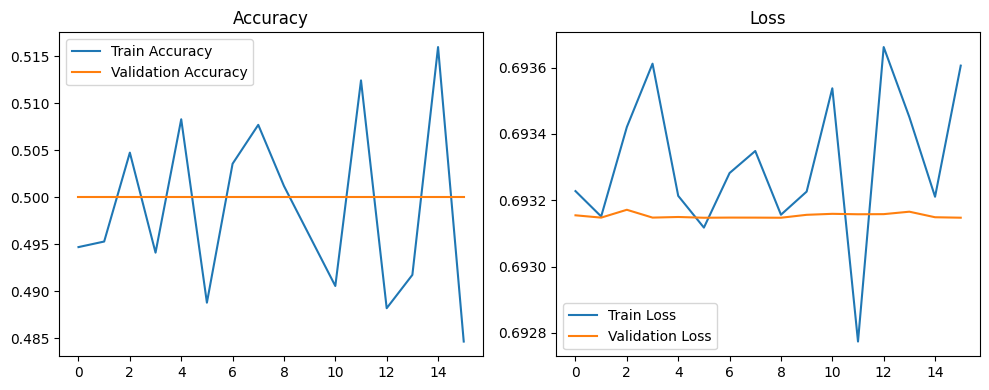

In [271]:
loss_acc_history(alexnet_da_hist)

### 4) 예측 및 평가
* 여러번 학습해도 전부 0이나 1로 예측하는 문제를 벗어나지 못함.

In [272]:
x_test_da = x_test_an.copy()

In [273]:
y_pred_an_da = model_an.predict(x_test_da).reshape(-1)
y_pred_an_da.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(122,)

In [274]:
y_pred_an_da[:5]

array([0.49986818, 0.49986818, 0.49986818, 0.49986818, 0.49986818],
      dtype=float32)

In [275]:
# y_pred가 확률 값으로 나오므로 평가를 위해 값을 변형
y_pred_an_da2 = np.where(y_pred_an_da > 0.5, 1 , 0)
y_pred_an_da2[:5]

array([0, 0, 0, 0, 0])

In [277]:
print(confusion_matrix(y_test, y_pred_an_da2))
print(classification_report(y_test, y_pred_an_da2))

[[61  0]
 [61  0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        61
           1       0.00      0.00      0.00        61

    accuracy                           0.50       122
   macro avg       0.25      0.50      0.33       122
weighted avg       0.25      0.50      0.33       122



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [338]:
result_df = df_accf1_concat(y_pred_an_da2, 'AlexNet_DataAug')
result_df

,Accuracy,F1_Score
AlexNet,0.7541,0.7000
VGG16,0.4754,0.6322
My_Img320,0.6885,0.7246
AlexNet_DataAug,0.5000,0.0000


## 7> 모델5 InceptionV3 전이학습 + Data Augmentation

### 1) 구조 설계

In [278]:
AN_input_size

227

In [279]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [281]:
# 세션 클리어, 모델 선언
clear_session()
model5 = Sequential()

# 모델 조립
In_V3 = InceptionV3(weights='imagenet',
                    include_top=False,
                    input_shape=(AN_input_size, AN_input_size, 3))

model5.add( In_V3 )
model5.add( BatchNormalization() )
model5.add( Flatten() )
model5.add( Dropout(0.25) )
model5.add( Dense(1, activation='sigmoid') )

# 컴파일
model5.compile(loss=binary_crossentropy, metrics=['accuracy'], optimizer=keras.optimizers.SGD(learning_rate=0.0001))

# 요약
model5.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 5, 5, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        51,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,862,177 (83.40 MB)

 Trainable params: 21,823,649 (83.25 MB)

 Non-trainable params: 38,528 (150.50 KB)

### 2) 학습
* ~~이미지 사이즈 조정~~
* ~~정규화~~
* EarlyStopping

In [282]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

In [283]:
inv3_hist = model5.fit(x_train_da, y_train_da,
                       validation_data=(x_val_da, y_val_da), callbacks=[es],
                       epochs=1000, verbose=1)

Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5056 - loss: 0.8044 - val_accuracy: 0.4792 - val_loss: 0.7413
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 228ms/step - accuracy: 0.5699 - loss: 0.7816 - val_accuracy: 0.4875 - val_loss: 0.7087
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.5881 - loss: 0.7209 - val_accuracy: 0.5208 - val_loss: 0.7201
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.6291 - loss: 0.6770 - val_accuracy: 0.6125 - val_loss: 0.7037
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.6559 - loss: 0.6468 - val_accuracy: 0.5875 - val_loss: 0.7125
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.6668 - loss: 0.6429 - val_accuracy: 0.6375 - val_loss: 0.6468
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.6806 - loss: 0.5777 - val_accuracy: 0.6833 - val_loss: 0.6398
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.6927 - loss: 0.6

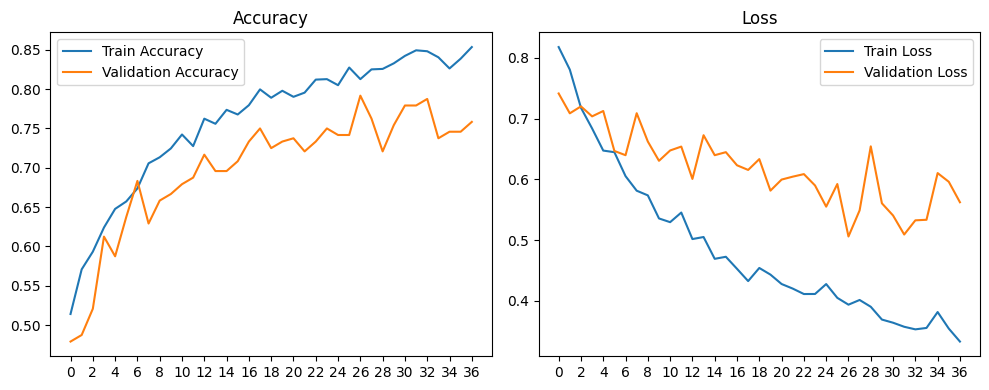

In [284]:
loss_acc_history(inv3_hist)

### 3) 예측 및 평가

In [285]:
y_pred_in = model5.predict(x_test_da).reshape(-1)
y_pred_in.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


(122,)

In [286]:
y_pred_in[:5]

array([0.00231052, 0.09704717, 0.99997365, 0.9995901 , 0.9969819 ],
      dtype=float32)

In [287]:
# y_pred가 확률 값으로 나오므로 평가를 위해 값을 변형
y_pred_in2 = np.where(y_pred_in > 0.5, 1 , 0)
y_pred_in2[:5]

array([0, 0, 1, 1, 1])

In [290]:
print(confusion_matrix(y_test, y_pred_in2))
print(classification_report(y_test, y_pred_in2))

[[51 10]
 [11 50]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        61
           1       0.83      0.82      0.83        61

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122



In [339]:
result_df = df_accf1_concat(y_pred_in2, 'InceptionV3_DataAug')
result_df

,Accuracy,F1_Score
AlexNet,0.7541,0.7000
VGG16,0.4754,0.6322
My_Img320,0.6885,0.7246
AlexNet_DataAug,0.5000,0.0000
InceptionV3_DataAug,0.8279,0.8264
